In [7]:
import re
import pickle  # if you need it later; not used here

# Path to the log file
log_file_path = '../femnist_logging'

# Regex patterns
finished_pattern = re.compile(r'client (\d+) finished')
selected_pattern = re.compile(r'Selected \d+ participants to run: \[([0-9,\s]+)\]')

# Lists to collect IDs (with duplicates)
finished_ids = []
selected_ids = []

with open(log_file_path, 'r') as f:
    for line in f:
        # Check for "client X finished" lines
        m_fin = finished_pattern.search(line)
        if m_fin:
            finished_ids.append(int(m_fin.group(1)))
        
        # Check for "Selected ... participants" lines
        m_sel = selected_pattern.search(line)
        if m_sel:
            # Extract the comma-separated list inside the brackets
            id_list_str = m_sel.group(1)
            # Split on commas and strip whitespace, convert to int
            ids = [int(x.strip()) for x in id_list_str.split(',') if x.strip()]
            selected_ids.extend(ids)

# Count occurrences
from collections import Counter
finished_counts = Counter(finished_ids)
selected_counts = Counter(selected_ids)

# Find IDs with mismatched counts
all_ids = set(finished_counts) | set(selected_counts)
mismatches = {cid: (finished_counts.get(cid, 0), selected_counts.get(cid, 0))
              for cid in all_ids
              if finished_counts.get(cid, 0) != selected_counts.get(cid, 0)}

# Print results
if mismatches:
    print("IDs with different occurrence counts between 'finished' and 'selected':")
    for cid, (fin_cnt, sel_cnt) in sorted(mismatches.items()):
        print(f"  Client {cid}: finished={fin_cnt}, selected={sel_cnt}")
else:
    print("All client IDs appear the same number of times in both collections.")

IDs with different occurrence counts between 'finished' and 'selected':
  Client 1292: finished=0, selected=1


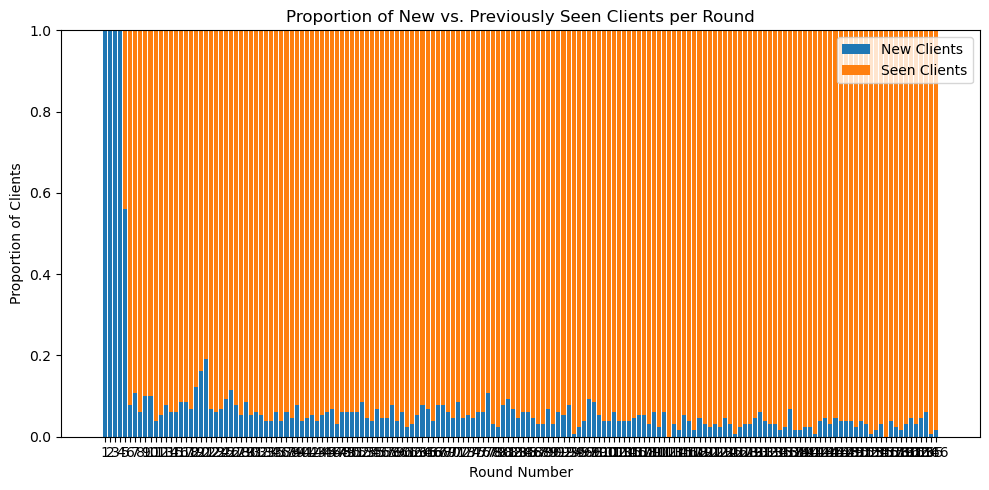

In [1]:
import re
import matplotlib.pyplot as plt

# Path to your log file (adjust as needed)
log_file = "../run_global_loggings/femnist/blissA_165_fedprox_final"

# Regex to capture the list of client IDs in each "Selected ..." line
pattern = re.compile(r"Selected \d+ participants to run: \[([0-9,\s]+)\]")

# Parse the file and extract one list of IDs per round
round_lists = []
with open(log_file, "r") as f:
    for line in f:
        m = pattern.search(line)
        if m:
            ids = [int(x) for x in m.group(1).split(",")]
            round_lists.append(ids)

# Track which clients have been seen so far
seen = set()
new_counts = []
seen_counts = []

for ids in round_lists:
    new = sum(1 for i in ids if i not in seen)
    seen_cnt = len(ids) - new
    new_counts.append(new)
    seen_counts.append(seen_cnt)
    seen.update(ids)

# Compute proportions for each round
totals = [len(ids) for ids in round_lists]
new_props = [n/t for n, t in zip(new_counts, totals)]
seen_props = [s/t for s, t in zip(seen_counts, totals)]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))
round_idx = list(range(1, len(round_lists) + 1))

ax.bar(round_idx, new_props, label="New Clients")
ax.bar(round_idx, seen_props, bottom=new_props, label="Seen Clients")

ax.set_xlabel("Round Number")
ax.set_ylabel("Proportion of Clients")
ax.set_title("Proportion of New vs. Previously Seen Clients per Round")
ax.set_xticks(round_idx)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()